<a href="https://colab.research.google.com/github/ramapu12/trabajoFinal/blob/main/trabajoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columnas después de limpiar los nombres: ['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_Mortality', 'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B', 'Measles', 'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness_1-19_years', 'thinness_5-9_years', 'Income_composition_of_resources', 'Schooling']
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores parámetros encontrados: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 1.55
RMSE: 2.28
R²: 0.94


<ipython-input-19-2a6ff3008db1>:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Life_expectancy', y='Country', data=top, palette='Greens_r', ax=ax_top)
<ipython-input-19-2a6ff3008db1>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Life_expectancy', y='Country', data=bottom, palette='Reds', ax=ax_bottom)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eeeafeec30819e37c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


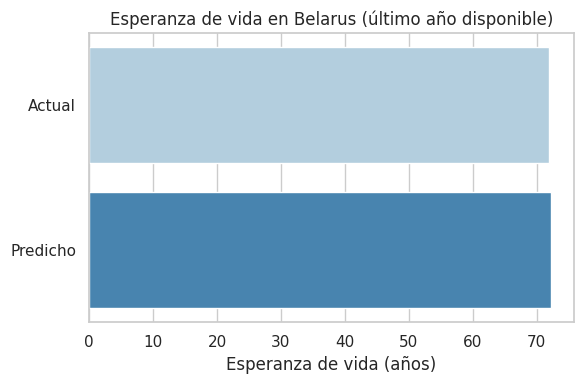

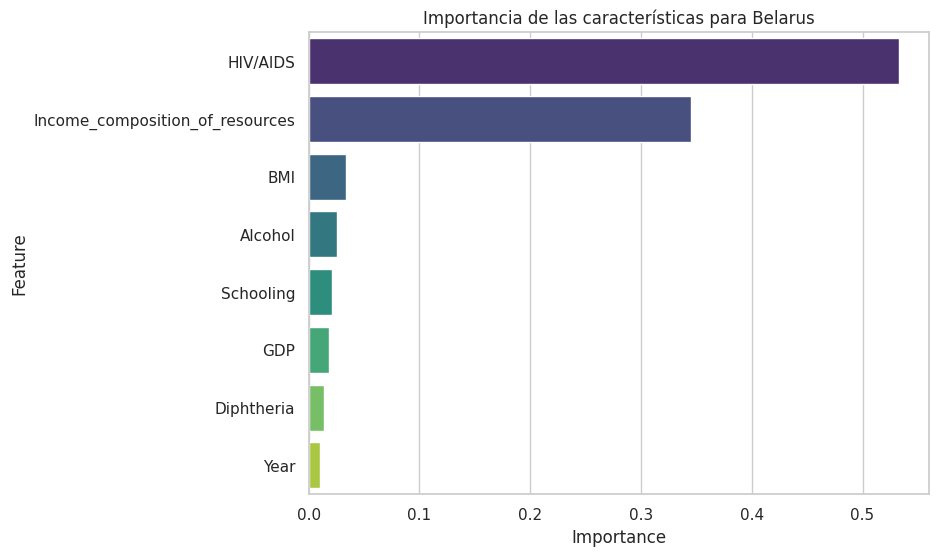

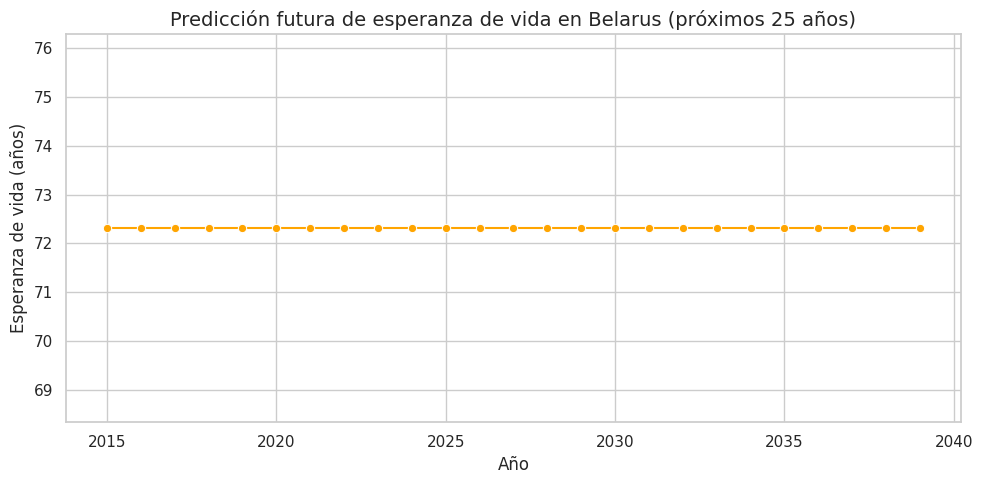

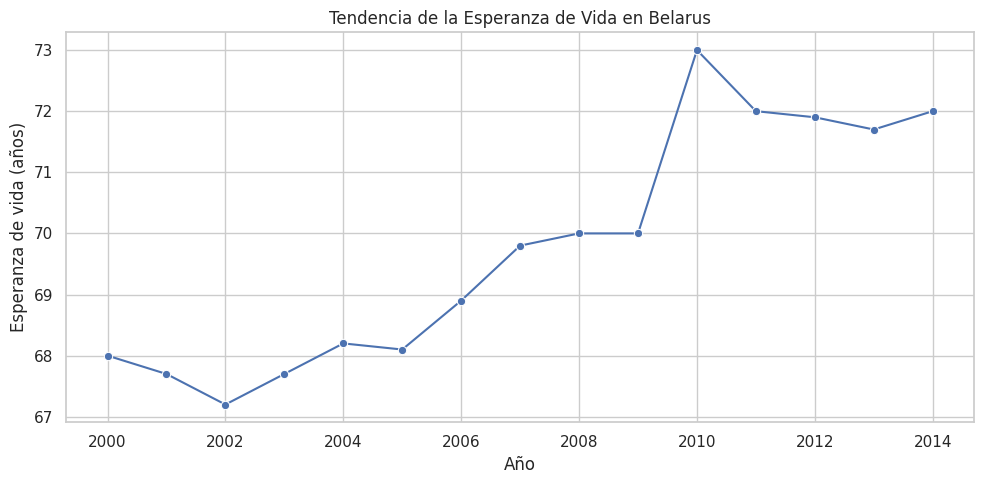

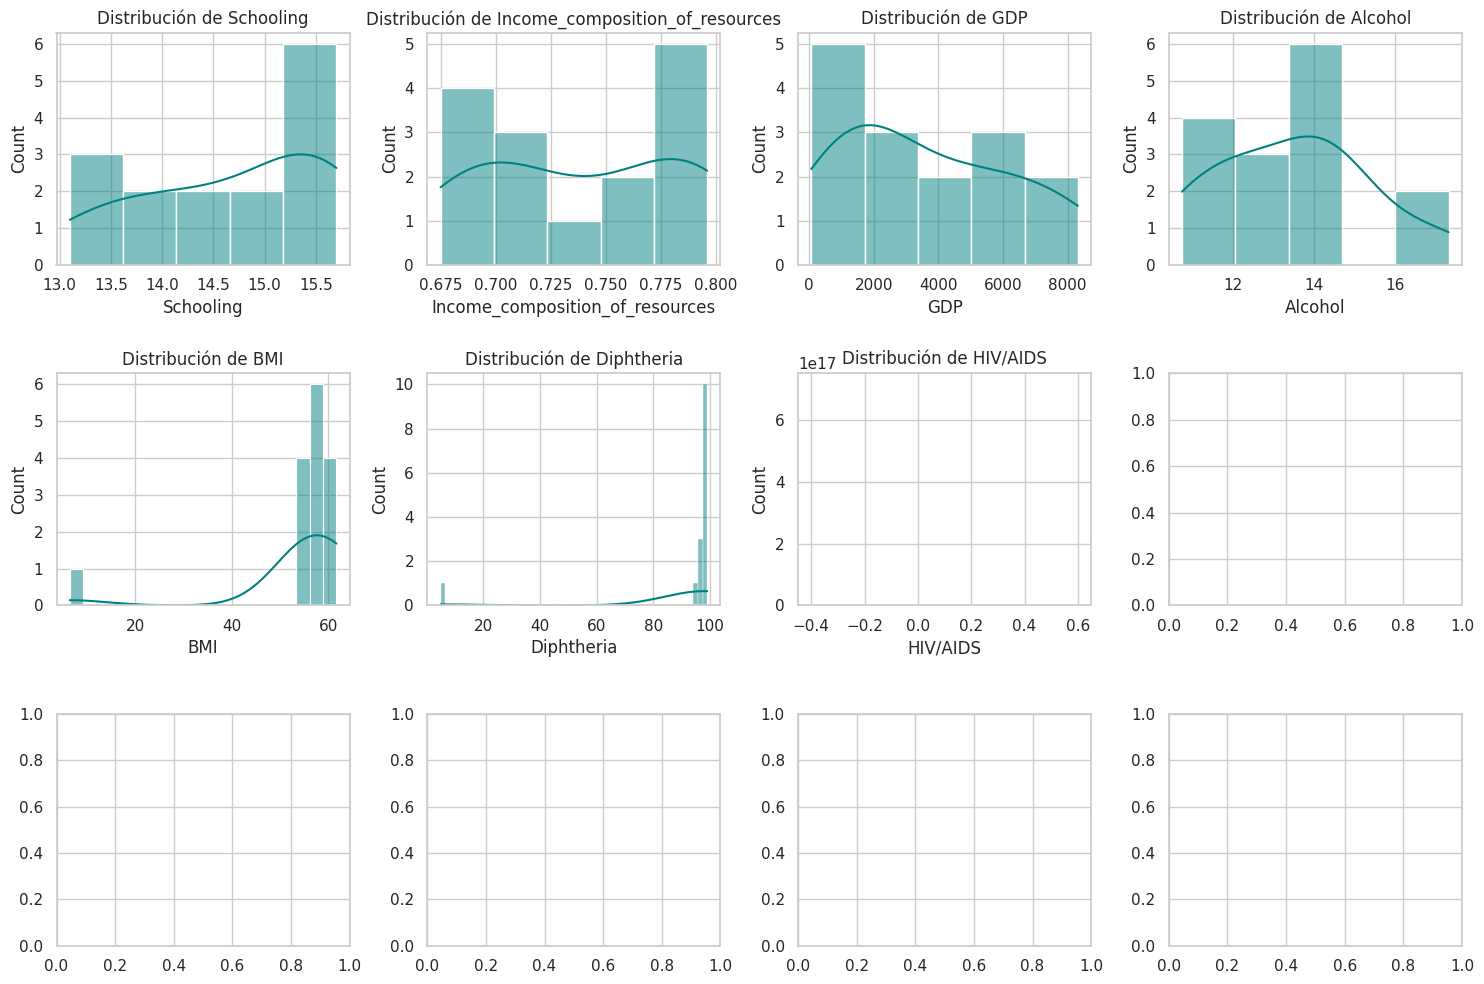

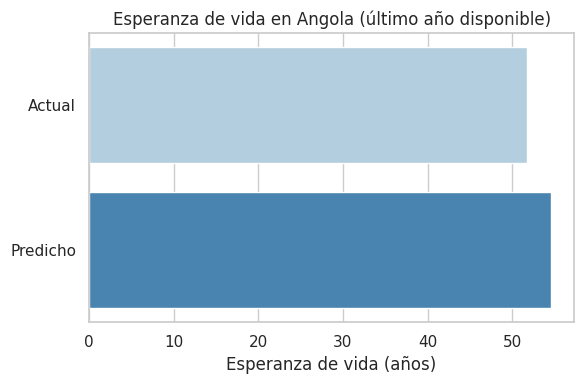

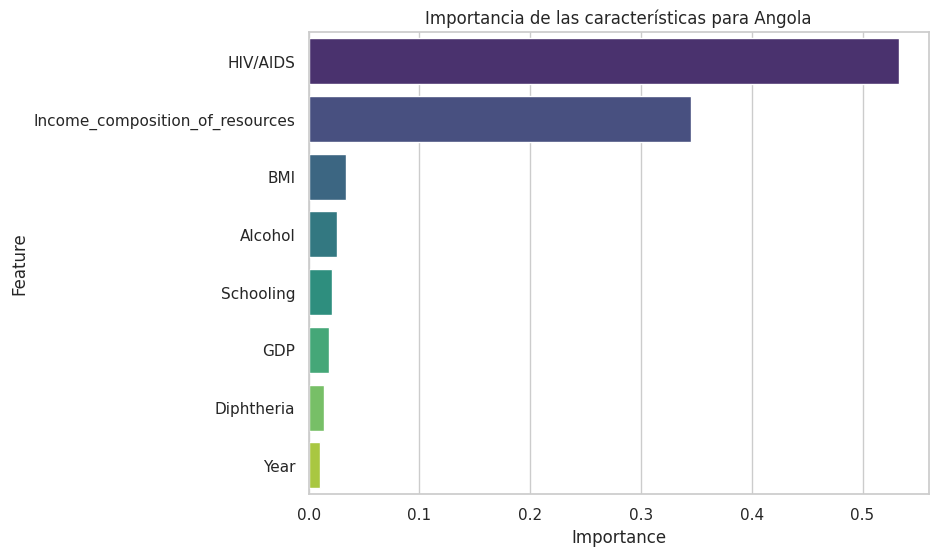

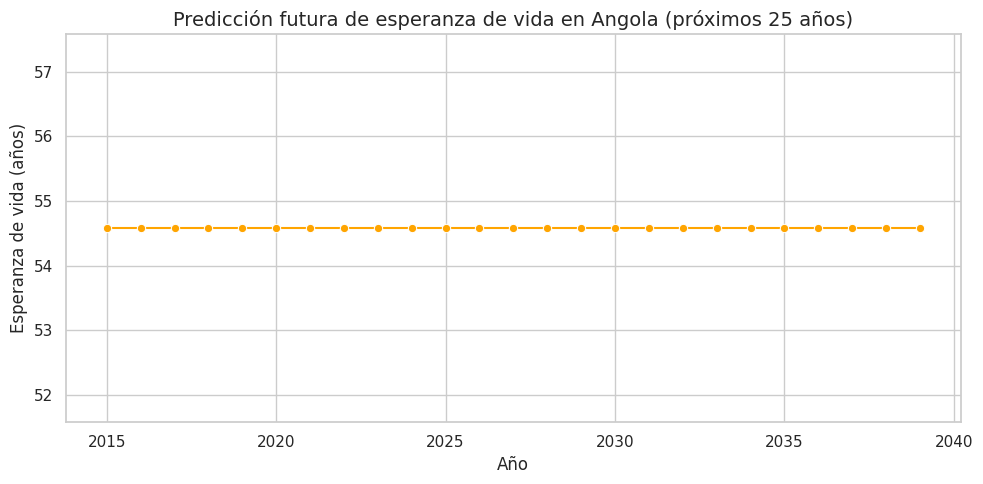

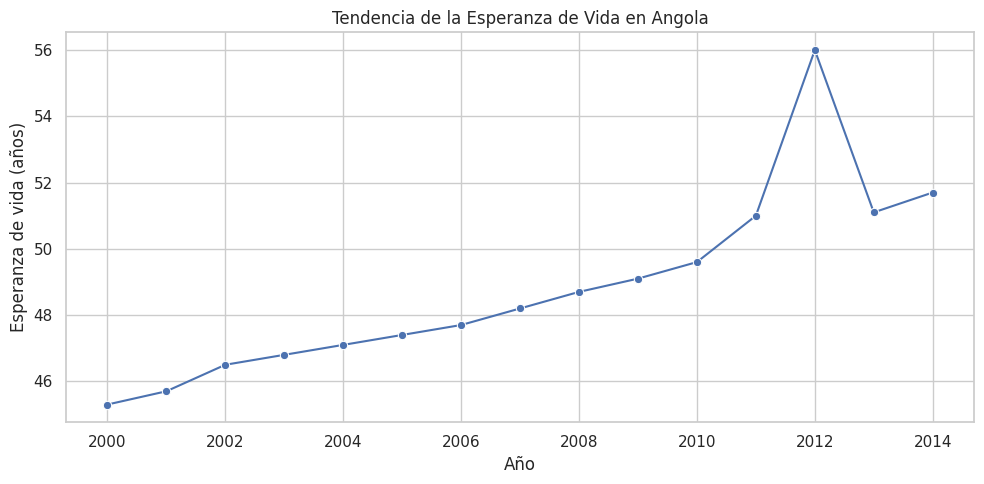

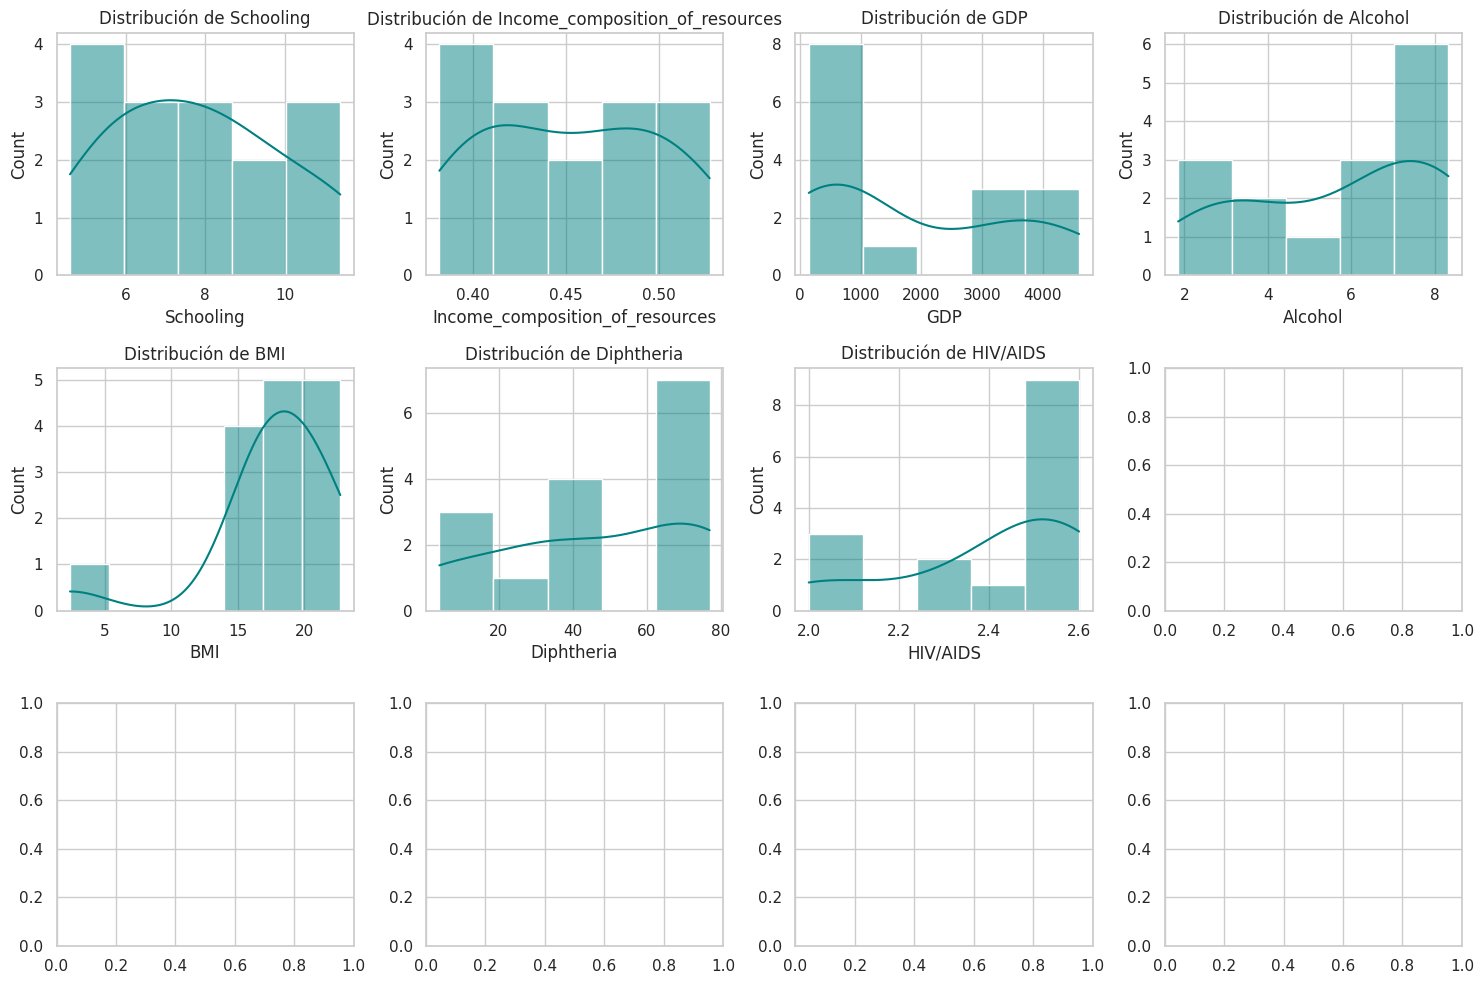

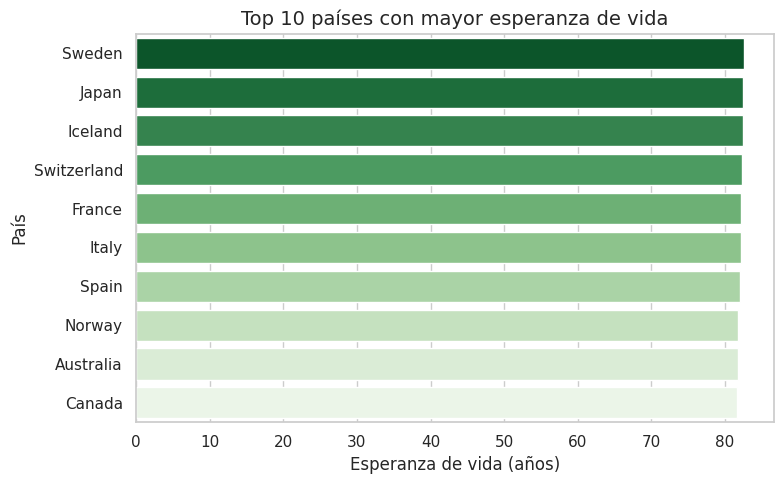

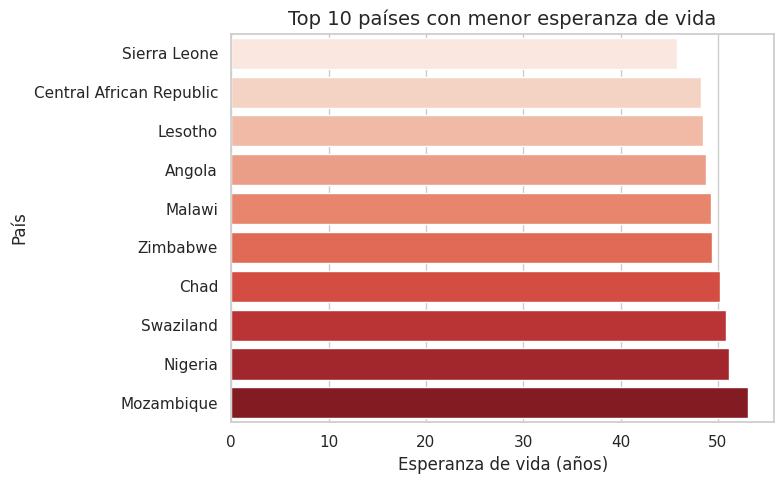

In [19]:
# ✅ Instalar dependencias necesarias (solo la primera vez)
!pip install gradio seaborn scikit-learn --quiet

# ✅ Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Para Google Colab
%matplotlib inline

# 🌍 Cargar el dataset
url = 'https://raw.githubusercontent.com/ramapu12/trabajoFinal/59399a459ba091dfd304faa2e1bdd509b56d5477/Life%20Expectancy%20Data.csv'
df = pd.read_csv(url)

# Limpiar nombres de columnas (eliminar espacios extra y reemplazar por guiones bajos)
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)

# Mostrar columnas para verificar
print("Columnas después de limpiar los nombres:", df.columns.tolist())

# Variables relevantes para el modelo (sin 'Percentage_expenditure')
variables_modelo = [
    'Life_expectancy', 'Year', 'Country', 'Schooling',
    'Income_composition_of_resources', 'GDP', 'Alcohol',
    'BMI', 'Diphtheria', 'HIV/AIDS'
]

# Filtrar y eliminar filas con valores nulos
df = df[variables_modelo].dropna()
paises = sorted(df['Country'].unique())

# 🎯 Entrenar modelo Random Forest
X = df.drop(columns=['Life_expectancy', 'Country'])
y = df['Life_expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de hiperparámetros usando GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid_search.best_params_)

# Usar el modelo con los mejores parámetros
rf_ajustado = grid_search.best_estimator_

# 🎯 Evaluación del modelo
y_pred = rf_ajustado.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# 🎨 Función para predecir la esperanza de vida con Random Forest
def predecir_rf(pais):
    datos_pais = df[df['Country'] == pais]
    entrada = datos_pais.sort_values(by='Year', ascending=False).iloc[0]
    X_input = entrada.drop(labels=['Life_expectancy', 'Country'])
    prediccion = rf_ajustado.predict([X_input])[0]

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=[entrada['Life_expectancy'], prediccion], y=['Actual', 'Predicho'], palette='Blues', ax=ax)
    ax.set_title(f'Esperanza de vida en {pais} (último año disponible)')
    ax.set_xlabel('Esperanza de vida (años)')
    plt.tight_layout()

    diferencia = prediccion - entrada['Life_expectancy']
    resumen = f"📊 Modelo predice **{prediccion:.2f} años** (actual: {entrada['Life_expectancy']:.2f}) ➜ Diferencia: **{diferencia:.2f} años**"

    importances = rf_ajustado.feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    fig_importance, ax_importance = plt.subplots(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax_importance, palette='viridis')
    ax_importance.set_title(f'Importancia de las características para {pais}')

    future_years = np.arange(datos_pais['Year'].max() + 1, datos_pais['Year'].max() + 26).reshape(-1, 1)
    future_input = np.tile(X_input, (25, 1))
    future_input[:, 0] = future_years.flatten()

    predictions_future = rf_ajustado.predict(future_input)

    fig_future, ax_future = plt.subplots(figsize=(10, 5))
    sns.lineplot(x=future_years.flatten(), y=predictions_future, marker='o', ax=ax_future, color='orange')
    ax_future.set_title(f'Predicción futura de esperanza de vida en {pais} (próximos 25 años)')
    ax_future.set_xlabel('Año')
    ax_future.set_ylabel('Esperanza de vida (años)')
    plt.tight_layout()

    return fig, resumen, fig_importance, fig_future

# 📊 Gráficos Top/Bottom países
def graficos_globales():
    mean_life = df.groupby('Country', as_index=False)['Life_expectancy'].mean()
    top = mean_life.sort_values(by='Life_expectancy', ascending=False).head(10)
    bottom = mean_life.sort_values(by='Life_expectancy', ascending=True).head(10)

    sns.set(style='whitegrid')

    fig_top, ax_top = plt.subplots(figsize=(8, 5))
    sns.barplot(x='Life_expectancy', y='Country', data=top, palette='Greens_r', ax=ax_top)
    ax_top.set_title('Top 10 países con mayor esperanza de vida', fontsize=14)
    ax_top.set_xlabel('Esperanza de vida (años)')
    ax_top.set_ylabel('País')
    plt.tight_layout()

    fig_bottom, ax_bottom = plt.subplots(figsize=(8, 5))
    sns.barplot(x='Life_expectancy', y='Country', data=bottom, palette='Reds', ax=ax_bottom)
    ax_bottom.set_title('Top 10 países con menor esperanza de vida', fontsize=14)
    ax_bottom.set_xlabel('Esperanza de vida (años)')
    ax_bottom.set_ylabel('País')
    plt.tight_layout()

    return fig_top, fig_bottom

# 🎨 Interfaz Gradio
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## Comparativa Global de Esperanza de Vida")

    fig_top, fig_bottom = graficos_globales()
    with gr.Row():
        with gr.Column():
            gr.Plot(fig_top)
        with gr.Column():
            gr.Plot(fig_bottom)

    gr.Markdown("---")
    gr.Markdown("## Predicción por País (Random Forest)")

    with gr.Row():
        pais_input_rf = gr.Dropdown(choices=paises, label="Selecciona un país")

    plot_rf = gr.Plot(label="Predicción RF")
    resumen_rf = gr.Markdown()
    importance_plot = gr.Plot(label="Importancia de las características")
    future_plot = gr.Plot(label="Predicción futura (próximos 25 años)")

    pais_input_rf.change(fn=predecir_rf, inputs=pais_input_rf, outputs=[plot_rf, resumen_rf, importance_plot, future_plot])

# 🚀 Ejecutar la app Gradio
demo.launch(share=True)
